# Sweeping

In [1]:
from __future__     import annotations
from collections    import UserString
from typing         import Sequence, List, Tuple, ValuesView
from string         import ascii_letters
from datetime       import datetime

import colorsys
import torch
from qtorch.quant import Quantizer
import numpy as np
import graphviz

from tqdm import tqdm, trange
from algebra import contract_up, sep_partial_dm_torch
from utils import adjust_lightness, one_epoch_one_tensor_torch, get_stripeimage_data_loaders, class_loss
from matplotlib import colors, colormaps


In [2]:
def inv_permutation(p: Sequence[int]) -> List[int]:
    return [p.index(i) for i in range(len(p))]

In [19]:


########## CLASSES FOR TENSOR INDEXING ##########
#################################################

# class which represent a generic tensor index,
# it is used to identify a tensor in the TTN.
# It is composed by a name and a list of indices
class TIndex:
    def __init__(self, name: str, inds: Sequence[str] | np.ndarray):
        self.__name = name
        self.__tindices = np.array(inds, dtype=np.str_) # problems with string lenghts
        self.__ndims = len(inds)
    
    def __getitem__(self, key: int) -> str:
        return self.__tindices[key]
    
    def __setitem__(self, key: int, value: str):
        old_len = self.__tindices.dtype.itemsize / 4
        new_len = max(old_len, len(value))
        self.__tindices = self.__tindices.astype(f"<U{new_len:.0f}")
        self.__tindices[key] = value
    
    @property
    def name(self):
        return self.__name 

    @property
    def indices(self):
        return self.__tindices
    
    @property
    def ndims(self):
        return self.__ndims

    
    ''' I do not want them to be changed by design   
    @indices.setter
    def indices(self, value: Sequence[str]):
        self.__indices = value
    '''
    
    def __eq__(self, __value: TIndex | str) -> bool:
        if isinstance(__value, str):
            return self.__name == __value
        return self.__name == __value.name and np.all(self.__tindices == __value.indices)
    
    def __gt__(self, __value: TIndex | str) -> bool:
        compare = __value if isinstance(__value, str) else __value.name
        try:    compare_layer = int(compare.split('.')[0])
        except: compare_layer = np.inf
        try:    self_layer = int(self.__name.split('.')[0])
        except: self_layer = np.inf

        if self_layer > compare_layer:
            return True
        elif self_layer == compare_layer:
            return int(self.__name.split('.')[1]) > int(compare.split('.')[1])
        return False
    
    def __lt__(self, __value: TIndex | str) -> bool:
        compare = __value if isinstance(__value, str) else __value.name
        try:    compare_layer = int(compare.split('.')[0])
        except: compare_layer = np.inf
        try:    self_layer = int(self.__name.split('.')[0])
        except: self_layer = np.inf

        if self_layer < compare_layer:
            return True
        elif self_layer == compare_layer:
            return int(self.__name.split('.')[1]) < int(compare.split('.')[1])
        return False
    
    def __ge__(self, __value: TIndex | str) -> bool:
        return self.__gt__(__value) or self.__eq__(__value)
    
    def __le__(self, __value: TIndex | str) -> bool:
        return self.__lt__(__value) or self.__eq__(__value)
    
    def __hash__(self):
        return hash(self.__name)
    
    def __str__(self) -> str:
        return self.__name
    
    def __repr__(self) -> str:
        return 'TIndex: ' + self.__name
    
    def _repr_markdown_(self):
        return f'**{self.__repr__()}**'
    
    def _repr_html_(self):
        markdown_str = f'<details><summary><b style="color:#0088d9; font-size:100%; font-family: verdana, sans-serif">{self.__repr__()} </b></summary>'
        for index in self.__tindices:
            markdown_str += f'&emsp;&ensp; <b style="color:#be00d9">{index}</b><br>'
        return markdown_str + '</details>'
    

# class which represent a tensor index in the
# specific case of the Tree Tensor Network.
# It is created by an int representing the layer
# and an int representing the index in the layer
class TTNIndex(TIndex):
    def __init__(self, layer: int, layer_index: int):

        self.__layer = layer
        self.__layer_index = layer_index
        super(TTNIndex, self).__init__(f"{layer}.{layer_index}",
                                       [f"{layer+1}.{2*layer_index}", f"{layer+1}.{2*layer_index+1}", f"{layer}.{layer_index}"], 
                                       )
    
    @property
    def layer(self):
        return self.__layer
    
    @property
    def layer_index(self):
        return self.__layer_index

    def __repr__(self) -> str:
        return f"TTNIndex: {self.__layer}.{self.__layer_index}"


# MEMO: THIS CLASS IS NOT USED  
# class which represent the link between two tensors in the TTN
# it is composed by a source and a target tensor index, a dimension,
# a dependencies list and a name
class TLink:
    def __init__(self, source: TIndex, target: TIndex, dim: int, dependencies: List[TIndex] = [], name: str = None):
        self.__source = source
        self.__target = target
        self.__dim = dim
        self.__vector = None
        self.__has_updated_vector = False
        self.__name = name if name is not None else f"{source.name}"
        self.__dependencies = dependencies

    @property
    def source(self):
        return self.__source
    
    @property
    def target(self):
        return self.__target
    
    @property
    def name(self):
        return self.__name
    
    @property
    def vector(self):
        if self.__has_updated_vector:
            return self.__vector
        elif self.__vector is not None:
            raise ValueError(f"No vector is set for TLink {self.__name}.")
        else:
            raise ValueError(f"TLink {self.__name} vector is not updated.")
        
    @vector.setter
    def vector(self, value):
        self.__vector = value
        self.__has_updated_vector = True

    @property
    def is_updated(self):
        return self.__has_updated_vector
    
    def depends_on(self, __value: TIndex | str) -> bool:
        return __value in self.__dependencies


########## CLASSES FOR TTN ##########
#####################################

# class representing a Tree Tensor Network.
# Here we define its structure, relying upon a
# simple dictionary of torch tensors and TTNIndices.
# Some useful methods are defined to access the tensors,
# initialize them and propagate data through the network.
class TTN:
    def __init__(
        self,
        n_features,
        n_phys=2,
        n_labels=2,
        label_tag="label",
        bond_dim=4,
        dtype=torch.cdouble,
        device="cpu",
        quantizer = None
    ):
        if (n_features % 2) != 0:
            raise ValueError(f"n_features must be  power of 2, got: {n_features}")

        self.n_features = n_features
        self.n_phys     = n_phys
        self.n_labels   = n_labels
        self.label_tag  = label_tag
        self.bond_dim   = bond_dim
        self.device     = device

        self.quantizer  = quantizer

        self.__dtype    = dtype
        self.__n_layers = int(np.log2(n_features))
        self.__tensors  = []
        self.__indices  = [TTNIndex(l, i) for l in range(self.__n_layers) for i in range(2**l)]
        # label top edge as label
        self.__indices[0][2] = label_tag
        # label bottom edges as data
        for ttnindex in self.__indices[-2**(self.__n_layers-1):]:
            ttnindex[0] = f'data.{ttnindex[0].split(".")[1]}'
            ttnindex[1] = f'data.{ttnindex[1].split(".")[1]}'
        # convert to numpy array for easier indexing
        self.__indices = np.asarray(self.__indices)

        self.__center = None

        self.__initialized = False

        ## INITIALIZE TENSORS ##
        # add first tensor with special index
        if not (self.__n_layers - 1):
            self.__tensors.append(
                torch.rand(
                    size=(self.n_phys, self.n_phys, self.n_labels),
                    dtype=self.__dtype,
                    device=self.device
                )
            )
        else:
            dim = min(self.n_phys**2**(self.__n_layers-1), self.bond_dim)
            self.__tensors.append(
                torch.rand(
                    size=(dim, dim, self.n_labels),
                    dtype=self.__dtype,
                    device=self.device
                )
            )

        for l in range(1, self.__n_layers - 1):  # constructing the ttn starting from the top
            dim_pre = min(self.n_phys**2**(self.__n_layers - l - 1), self.bond_dim)
            dim_post = min(self.n_phys **2** (self.__n_layers - l ), self.bond_dim)
            self.__tensors.extend(
                [
                    torch.rand(
                        size=[dim_pre] * 2 + [dim_post],
                        dtype=self.__dtype,
                        device=self.device
                    )
                    if np.random.rand() < 0.5
                    else torch.eye(
                        dim_pre**2, 
                        dtype=self.__dtype,
                        device=self.device)
                        .reshape(dim_pre, dim_pre, -1)[:, :, :dim_post]
                    for i in range(2**l)
                ]
            )

        dim = min(self.n_phys**2, self.bond_dim)
        self.__tensors.extend(
            [
                torch.rand(
                    size=[self.n_phys] * 2 + [dim],
                    dtype=self.__dtype,
                    device=self.device
                )
                for i in range(2 ** (self.__n_layers - 1))
            ]
        )
        ########################
        self.__tensor_map = dict(zip(self.__indices, self.__tensors))
    
    def __getitem__(self, key: Sequence[TTNIndex | str] | str | int | slice) -> dict[TTNIndex, torch.Tensor]:

        if isinstance(key, int):
            return {self.__indices[key]: self.__tensor_map[self.__indices[key]]}
        elif isinstance(key, str):
            return {self.__indices[self.__indices==key].item(): self.__tensor_map[key]}
        elif isinstance(key, Sequence):
            return {k if isinstance(k, TTNIndex) else self.__indices[self.__indices==k].item(): self.__tensor_map[k] for k in key}
        elif isinstance(key, slice):
            return {k: self.__tensor_map[k] for k in self.__indices[key]}
        else:
            raise TypeError(f"Invalid argument type: {type(key)}")
        
    @property
    def indices(self):
        return self.__indices
    
    @property
    def center(self):
        return self.__center
    
    @center.setter
    def center(self, value: TTNIndex | str):
        if isinstance(value, str):
            value = self.__indices[self.__indices==value].item()
        self.__center = value
    
    @property
    def tensors(self):
        return self.__tensors
    
    @tensors.setter
    def tensors(self, value: Sequence[torch.Tensor] | torch.nn.ParameterList):
        self.__tensor_map = dict(zip(self.__indices, value))    # had to put this line before because the setter stops the execution of the rest of the function
        self.__tensors = value

    @property
    def dtype(self):
        return self.__dtype
    
    @property
    def n_layers(self):
        return self.__n_layers
    
    @property
    def initialized(self):
        return self.__initialized
        
    def __repr__(self) -> str:
        return f"TTN"
    
    def _repr_html_(self):
        markdown_str = f'<details><summary><b style="color:#d95100; font-size:100%; font-family: verdana, sans-serif">{self.__repr__()} </b></summary>'
        for tindex in self.__indices:
            markdown_str += f'{tindex._repr_html_()}'
        return markdown_str + '</details>'
    
    def get_branch(self, tindex: TIndex | TTNIndex | str, till: str='data') -> dict[TTNIndex | TIndex, torch.Tensor]:
        """
        Returns a dictionary of tensors and indices of the branch starting at tindex, going down to the bottom of the TTN.
        """
        if isinstance(tindex, str):
            if 'data' in tindex:
                tindex = TIndex(tindex, [tindex])
            elif tindex not in self.__indices:
                raise ValueError("Error 404: tindex must be a valid TTNIndex")
            else:
                tindex = self.__indices[self.__indices==tindex].item()
                
        branch_indices = [tindex]
        branch_layer   = [tindex]
        while till not in branch_layer[0][0]:
            branch_layer = [self.__indices[self.__indices==tindex[i]].item() for tindex in branch_layer for i in range(tindex.ndims-1)] 
            branch_indices.extend(branch_layer) 

        return {tindex: torch.zeros(list(self.get_layer(-1).values())[int(tindex.name.split('.')[1]) // 2].shape)} if 'data' in tindex.name else self.__getitem__(branch_indices)
    
    def get_layer(self, layer: int) -> dict[TTNIndex, torch.Tensor]:
        """
        Returns a dictionary of tensors and indices of the layer layer.
        """
        if layer >= 0:
            if layer >= self.__n_layers:
                raise ValueError(f"layer must be a valid layer index. This TTN has only {self.__n_layers} layers, got: {layer}")
            return {tindex: self.__tensor_map[tindex] for tindex in self.__indices if int(tindex.name.split('.')[0]) == layer}
        else:
            if layer < -self.__n_layers:
                raise ValueError(f"layer must be a valid layer index. This TTN has only {self.__n_layers} layers, got: {layer}")
            return {tindex: self.__tensor_map[tindex] for tindex in self.__indices if int(tindex.name.split('.')[0]) == self.__n_layers + layer}
    
    
    def _propagate_data_through_branch_(self, data: dict[TIndex, torch.Tensor], branch: dict[TTNIndex, torch.Tensor], keep=False, pbar=None, quantize=False) -> dict[TIndex, torch.Tensor] :
        """
        Propagates data through a branch of the TTN.
        """

        sorted_branch_keys = sorted(branch.keys(), reverse=True)
        last_idx = sorted_branch_keys[-1]
        branch_data = data | branch
        for tindex in sorted_branch_keys:
            if pbar is not None:
                pbar.set_postfix_str(f"contracting {tindex.name}")
            branch_data[tindex] = contract_up(branch_data[tindex].contiguous(), [branch_data[tindex[0]], branch_data[tindex[1]]], self.quantizer if quantize else None)
            if pbar is not None:
                pbar.update(1)
                pbar.set_postfix_str(f"contracted {tindex.name}")
                

        if not keep:
            result = branch_data[last_idx].clone()
            del branch_data

        return {key: branch_data[key] for key in sorted_branch_keys} if keep else {TIndex(last_idx.name, last_idx[2]): result}

    def path_from_to(self, source: TIndex | TTNIndex | str, target: TIndex | TTNIndex | str) -> List[TTNIndex]:
        """
        Returns a list of TTNIndex which are the path from the source to the target.
        """


        if isinstance(target, str):
            if 'data' in target:
                target = TIndex(target, [target])
            elif target not in self.__indices:
                raise ValueError("Error 404: target must be a valid TTNIndex")
            else:
                target = self.__indices[self.__indices==target].item()
        elif type(target) == TIndex:
            if 'data' not in target.name: raise ValueError("Error 404: target must be a valid TTNIndex")
        else:
            if target not in self.__indices:
                raise ValueError("Error 404: target must be a valid TTNIndex")
            

        if isinstance(source, str):
            if 'data' in source:
                source = TIndex(source, [source])
            elif source not in self.__indices:
                raise ValueError("Error 404: source must be a valid TTNIndex")
            else:
                source = self.__indices[self.__indices==source].item()
        elif type(source) == TIndex:
            if 'data' not in source.name: raise ValueError("Error 404: source must be a valid TTNIndex")
        else:
            if source not in self.__indices:
                raise ValueError("Error 404: source must be a valid TTNIndex")
            
        path = []
        while target != source:

            # we have to move up the tree until we intersect the branch containing the center
            while source not in self.get_branch(target).keys() if isinstance(source, TTNIndex) else source not in np.concatenate([tindex.indices for tindex in self.get_branch(target).keys()]):
                path.append(target)
                if isinstance(target, TTNIndex):
                    upname = f'{target.layer - 1}.{target.layer_index // 2}'
                else:
                    upname = f'{self.n_layers - 1}.{int(target.name.split(".")[1]) // 2}'
                target = self.__indices[self.__indices==upname].item()

            # if the target is above the center (its layer is lesser), we have to move down the tree
            while (target.layer if isinstance(target, TTNIndex) else self.n_layers) < (source.layer if isinstance(source, TTNIndex) else self.n_layers):
                path.append(target)
                if isinstance(source, TTNIndex):
                    if source in self.get_branch(target[0]).keys():
                        target = self.__indices[self.__indices==target[0]].item()
                    elif source in self.get_branch(target[1]).keys():
                        target = self.__indices[self.__indices==target[1]].item()
                    else:
                        raise ValueError("young padawan, you did not find your centro di gravità permanente")
                else:
                    if ('data' in target[0]) or ('data' in target[1]):
                        target = source
                    elif source in np.concatenate([tindex.indices for tindex in self.get_branch(target[0]).keys()]):
                        target = source if 'data' in target[0] else self.__indices[self.__indices==target[0]].item()
                    elif source in np.concatenate([tindex.indices for tindex in self.get_branch(target[1]).keys()]):
                        target = source if 'data' in target[1] else self.__indices[self.__indices==target[1]].item()
                    else:
                        raise ValueError("young padawan, you did not find your centro di gravità permanente")

        path.append(source)
        path.reverse()
        return path

    def path_center_to_target(self, target: TTNIndex | str) -> List[TTNIndex]:
        """
        Returns a list of TTNIndex which are the path from the center to the target.
        """

        if self.__center is None:
            raise ValueError("The TTN has not been canonicalized nor initialized yet so there is no central tensor.")
        
        return self.path_from_to(self.__center, target)

    def _sandwich_through_path(self, dataindex: TIndex | TTNIndex, data: torch.Tensor, path: Sequence[TTNIndex], pbar=None):
        """
        Propagates data through a path of the TTN.
        """
        #! treat the case in which the path passes through 0.0
        result = data
        index = dataindex
        for i, tindex in enumerate(path[:-1]):
            leg = np.nonzero(np.in1d(tindex.indices, index.indices))[0][0]
            other_idxs = [i for i in range(3) if i != leg]
            next_leg = np.nonzero(np.in1d(tindex.indices, path[i+1].indices))[0][0]
            next_other_idxs = [i for i in range(3) if i != next_leg]
            #leg = int(index.name.split('.')[-1]) % 2
            # contract the data matrix with the tensor
            tn_tensor = self.__tensor_map[tindex]
            result = torch.matmul(result, tn_tensor.permute([leg] + other_idxs)    \
                                                   .reshape(result.shape[-1], -1)).reshape(list(np.array(tn_tensor.shape)[[leg] + other_idxs]))    \
                                                                                  .permute(inv_permutation([leg] + other_idxs))
            # sandwich the previous result with the conjugate of the tensor
            result = torch.matmul(tn_tensor.permute(next_other_idxs + [next_leg]).reshape(-1, tn_tensor.shape[next_leg]).T.conj(),
                                  result.permute(next_other_idxs + [next_leg]).reshape(-1, tn_tensor.shape[next_leg]))
            index = tindex

        return index, result

    def canonicalize(self, target: TTNIndex | str, pbar=None):
        """
        Canonicalizes the TTN by moving the center eigenvalues
        to the target tensor through a QR decomposition.
        """

        if target not in self.__indices:
            raise ValueError("Error 404: target must be a valid TTNIndex")
        
        if isinstance(target, str):
            target = self.__indices[self.__indices==target].item()

        if self.__center is None:
            raise NotImplementedError("The TTN has not been initialized yet so there is no central tensor. Canonicalization w/out a central tensor is not implemented yet.")
        else:

            path = self.path_center_to_target(target)
            for i, tindex in enumerate(path[:-1]):
                if pbar is not None:
                    pbar.set_postfix_str(f"canonicalizing {tindex.name}")

                tensor_c = self.__tensor_map[tindex]

                # get the leg towards which we have to move the QR decomposition
                # both in the current tensor and in the next one
                next_leg_c = np.in1d(tindex.indices, path[i+1].indices)
                next_leg_n = np.in1d(path[i+1].indices, tindex.indices)
                next_leg_c_idx = np.where(next_leg_c)[0][0]
                next_leg_n_idx = np.where(next_leg_n)[0][0]

                # QR decomposition towards next tensor in path
                tensor_c, r = torch.linalg.qr(tensor_c.transpose(next_leg_c_idx, 2).reshape(-1, tensor_c.shape[next_leg_c_idx]))

                # reshape and transpose the current tensor to match the original shape
                tensor_c = tensor_c.reshape(self.__tensor_map[tindex].transpose(next_leg_c_idx, 2).shape)
                self.__tensor_map[tindex] = tensor_c.transpose(next_leg_c_idx, 2)
                
                # multiply the next tensor in path by the R matrix
                tensor_n = self.__tensor_map[path[i+1]]
                tensor_n = torch.matmul(r, tensor_n.transpose(next_leg_n_idx, 0).reshape(tensor_n.shape[next_leg_n_idx], -1))
                self.__tensor_map[path[i+1]] = tensor_n.reshape(self.__tensor_map[path[i+1]].transpose(next_leg_n_idx, 0).shape).transpose(next_leg_n_idx, 0)

                if pbar is not None:
                    pbar.update(1)
                    pbar.set_postfix_str(f"canonicalized {tindex.name}")

        self.__center = target
        self.__tensors = [self.__tensor_map[idx] for idx in self.__indices] #? this is a bit of a hack, but it works

    def get_do_dt(self, target: TTNIndex | str, data: dict[TIndex, torch.Tensor], pbar=None):
        """
        Returns the derivative of the output with respect to the target tensor.
        """

        if target not in self.__indices:
            raise ValueError("Error 404: target must be a valid TTNIndex")
        
        if isinstance(target, str):
            target = self.__indices[self.__indices==target].item()

        # get paths from each data tensor to the target tensor
        propagate_to_dict = {tindex: np.array(self.path_from_to(tindex, target)[1:]) for tindex in data.keys()}

        # unify the paths to the target tensor which share the same branch
        # and propagate the data through the TTN till the uppermost tensor
        # of the branch.

        # first search for paths with the top tensor (special case)
        tindices_w_top_in_path = [tindex for tindex, path in propagate_to_dict.items() if '0.0' in path]
        paths_top = [propagate_to_dict[tindex] for tindex in tindices_w_top_in_path]
        branch_ids_top = list(np.unique([branch_idx[np.nonzero(branch_idx == '0.0')[0][0] - 1] for branch_idx in paths_top]))

        # then add the paths which do not have the top tensor in their path
        branch_ids_no_top = [propagate_to_dict[tindex] for tindex in propagate_to_dict.keys() if tindex not in tindices_w_top_in_path]
        branch_ids_no_top = list(np.unique([path[np.nonzero(path == np.sort(path)[0])[0][0] - 1] for path in branch_ids_no_top if len(path) > 1]))

        if len(branch_ids_top) > 1 and len(branch_ids_no_top) > 0:
            raise Exception("The TTN has more than one branch with the top tensor and at least one branch without the top tensor. This case is not possible.")

        vectors = []
        branch_ids = branch_ids_top + branch_ids_no_top
        for branch_id in branch_ids:
            branch = self.get_branch(branch_id)
            vector = self._propagate_data_through_branch_(data, branch, keep=True, pbar=pbar)[branch_id]
            vectors.append(vector)
        vectors_dict = {tindex: vector for tindex, vector in zip(branch_ids, vectors)}

        if len(branch_ids_top) > 1: # this means we are optimizing the top tensor
            return {TIndex(tindex.name, tindex.indices[-1:]): vector for tindex, vector in zip(branch_ids_top, vectors)}

        # if we are optimizing a tensor in the middle of the TTN, we have to moveScreencast_.mp4 the vector below top
        # through top and down towards the target
        leg_to_contract = branch_ids_top[0].layer_index
        moving_down = torch.matmul(vectors[0], 
                                   self.__tensors[0].permute((leg_to_contract, not leg_to_contract, 2)) \
                                                    .reshape((vectors[0].shape[-1], -1)))               \
                      .reshape((vectors[0].shape[0], -1, self.n_labels))
        del vectors_dict[branch_ids_top[0]]

        # along this descent remember to contract with vectors of branches with no top
        remaining_path = paths_top[0]
        remaining_path = remaining_path[np.nonzero(remaining_path == '0.0')[0][0]+1:]
        for i, tindex in enumerate(remaining_path[:-1]):
            open_leg = remaining_path[i+1].layer_index % 2
            branch = tindex.indices[int(not open_leg)]

            contr_w_vector = torch.matmul(vectors_dict[branch], 
                                          self.__tensor_map[tindex].permute((int(not open_leg), open_leg, 2))       \
                                                                   .reshape((vectors_dict[branch].shape[-1], -1)))  \
                             .reshape((vectors_dict[branch].shape[0], -1, self.__tensor_map[tindex].shape[-1]))
            moving_down = torch.bmm(contr_w_vector, moving_down)

            del vectors_dict[branch], contr_w_vector

        result = {TIndex(target.name, ['b', target.indices[-1], 'label']): moving_down}
        # append unused branches
        for tindex, vector in vectors_dict.items():
            result[TIndex(tindex.name, ['b', tindex.indices[-1]])] = vector

        # append also data vectors which did not need to be propagated (case in which we are optimizing a tensor in the bottom layer)
        for tindex, vector in data.items():
            if propagate_to_dict[tindex][0] == target:
                result[tindex] = vector
        
        return result
    
    
    def normalize(self):
        if self.__center is None:
            raise ValueError("The TTN has not been canonicalized nor initialized yet so there is no central tensor. This case has not been implemented yet.")
        else:
            self.__tensor_map[self.__center] /= torch.linalg.vector_norm(self.__tensor_map[self.__center])
            self.__tensors[np.nonzero(self.__indices==self.__center)[0][0]] = self.__tensor_map[self.__center]


    def expectation(self, operators: dict[TIndex | TTNIndex, torch.Tensor], pbar=None):
        targets = [tindex for tindex in self.get_layer(-1).keys() if np.any(np.in1d(tindex.indices, list(operators.keys())))]
        if len(targets) > 0:
            target = targets[0]
            self.canonicalize(target, pbar=pbar)
        else:
            target = self.__center

        if len(operators) == 0:
            raise ValueError("No operators have been passed.")
        elif len(operators) == 1:
            tensor_tags = 'ijk'
            tensor_hc_tags = 'ijk'

            dataindex, operator = list(operators.items())[0]
            leg_idx = np.nonzero(np.in1d(target.indices, dataindex.indices))[0][0]
            operator_tags = ''.join([tensor_tags[leg_idx], 'a'])
            tensor_hc_tags = tensor_hc_tags.replace(tensor_hc_tags[leg_idx], 'a')

            contr_str = ','.join([tensor_tags, tensor_hc_tags, operator_tags]) + '->'

            # FINALLY
            result = torch.einsum(contr_str, self.__tensor_map[target], self.__tensor_map[target].conj(), operator)

            return result

        propagate_to_dict = {tindex: self.path_from_to(tindex, target)[1:] for tindex in operators.keys()}

        indices_prop_through = np.unique(np.concatenate([np.array(path) for path in propagate_to_dict.values()]))
        # all the other tindeces contracts to the identity

        print(target)
        print(indices_prop_through)

        intersections_dict = {}
        for tindex, path in propagate_to_dict.items():
            intersections_ls = [np.where(np.in1d(path, other_path))[0][0] for index, other_path in propagate_to_dict.items() if index != tindex]
            intersections_dict[tindex] = np.sort(intersections_ls)[0]

        intermediate_results = operators

        to_intersect = {}
        
        while not np.all(np.array([tindices[0] for tindices in propagate_to_dict.values()]) == target): # sum(list(intersections_dict.values())) != 0: #! to correct, incorrect results when all nodes has zero as first intersection but some has to be propagated yet
            #! now we have an infinite loop
            for dataindex, path in propagate_to_dict.items():
                if path[0] == target:
                    continue
                elif intersections_dict[dataindex] == 0:
                    # in this case we have to do nothing but wait for others to contract
                    if path[intersections_dict[dataindex]] in to_intersect.keys():
                        to_intersect[path[intersections_dict[dataindex]]].append(dataindex)
                    else:
                        to_intersect[path[intersections_dict[dataindex]]] = [dataindex]
                else:
                    # in this case we have to contract the data through the path
                    # and then sandwich it 
                    index, result = self._sandwich_through_path(dataindex, intermediate_results[dataindex], path[:intersections_dict[dataindex]+1], pbar)
                    intermediate_results[index] = result
                    del intermediate_results[dataindex]

                    if path[intersections_dict[dataindex]] in to_intersect.keys():
                        to_intersect[path[intersections_dict[dataindex]]].append(index)
                    else:
                        to_intersect[path[intersections_dict[dataindex]]] = [index]

            to_del = []
            for tindex, indices in to_intersect.items():
                if len(indices) == 2:

                    tensor = self.__tensor_map[tindex]
                    # contract first index with tindex
                    leg_idx0 = np.nonzero(np.in1d(tindex.indices, indices[0].indices))[0][0]
                    other_idx = [i for i in range(3) if i != leg_idx0]
                    temp = torch.matmul(intermediate_results[indices[0]], tensor.permute([leg_idx0] + other_idx)  \
                                                                                .reshape(intermediate_results[indices[0]].shape[0], -1)).reshape(list(np.array(tensor.shape)[[leg_idx0] + other_idx])) \
                                                                                                                                        .permute(inv_permutation([leg_idx0] + other_idx))
                    # contract second index with tindex
                    leg_idx1 = np.nonzero(np.in1d(tindex.indices, indices[1].indices))[0][0]
                    other_idx = [i for i in range(3) if i != leg_idx1]
                    temp = torch.matmul(intermediate_results[indices[1]], temp.permute([leg_idx1] + other_idx)  \
                                                                              .reshape(intermediate_results[indices[1]].shape[0], -1)).reshape(list(np.array(temp.shape)[[leg_idx1] + other_idx])) \
                                                                                                                                      .permute(inv_permutation([leg_idx1] + other_idx))
                        
                    # contract tindex with its hermitian conjugate
                    other_idx = [i for i in range(3) if i not in [leg_idx0, leg_idx1]][0]
                    temp = torch.matmul(tensor.permute(leg_idx0, leg_idx1, other_idx).reshape(-1, tensor.shape[other_idx]).T.conj(), temp.permute(leg_idx0, leg_idx1, other_idx).reshape(-1, tensor.shape[other_idx]))

                    # add tindex to intermediate results
                    intermediate_results[tindex] = temp

                    # delete the two indices from intermediate_result and tindex from to_intersect
                    del intermediate_results[indices[0]], intermediate_results[indices[1]]
                    to_del.append(tindex)

            for tindex in to_del:
                del to_intersect[tindex]

            propagate_to_dict = {tindex: self.path_from_to(tindex, target)[1:] for tindex in intermediate_results.keys()}

            indices_prop_through = np.unique(np.concatenate([np.array(path) for path in propagate_to_dict.values()]))
            print(indices_prop_through)

            intersections_dict = {}
            for tindex, path in propagate_to_dict.items():
                try:
                    intersections_ls = [np.where(np.in1d(path, other_path))[0][0] for index, other_path in propagate_to_dict.items() if index != tindex]
                    intersections_dict[tindex] = np.sort(intersections_ls)[0]
                except Exception as e:
                    print(tindex, path)
                    raise e

        print('intermediate_results:', intermediate_results)
        print('to_intersect', to_intersect)
        print('prop_dict', propagate_to_dict)
        # now we have to contract the remaining tensors
        
        tensor_tags = 'ijk'
        tensor_hc_tags = 'ijk'
        other_letters = 'abc'
        operators_tags = []
        for i, tindex in enumerate(intermediate_results.keys()):
            leg_idx = np.nonzero(np.in1d(target.indices, tindex.indices))[0][0]
            operators_tags.append(''.join([tensor_tags[leg_idx], other_letters[i]]))
            tensor_hc_tags = tensor_hc_tags.replace(tensor_hc_tags[leg_idx], other_letters[i])

        contr_str = ','.join([tensor_tags, tensor_hc_tags] + operators_tags) + '->'

        # FINALLY
        result = torch.einsum(contr_str, self.__tensor_map[target], self.__tensor_map[target].conj(), *list(intermediate_results.values()))

        return result

    def entropy(self, link: str | TIndex | TTNIndex):
        """
        Returns the von Neumann entropy of the link.
        This can be calculated simply by canonicalizing
        the network towards the link and then decomposing
        the attached tensor via SVD.
        The coefficients in V give the entropy.
        """
        
        if isinstance(link, str):
            if 'data' in link or 'label' in link:
                link = TIndex(link, [link])
            elif link not in self.__indices:
                raise ValueError("Error 404: link must be a valid TTNIndex")
            else:
                link = self.__indices[self.__indices==link].item()
        elif type(link) == TIndex:
            if 'data' not in link.name and 'label' not in link.name: raise ValueError("Error 404: link must be a valid TTNIndex")
        else:
            if link not in self.__indices:
                raise ValueError("Error 404: link must be a valid TTNIndex")
        
        target, tensor = [(tindex, tensor) for tindex, tensor in self.__tensor_map.items() if link in tindex.indices][0]
        leg_idx = np.nonzero(target.indices == link)[0][0]
        other_idx = [i for i in range(3) if i != leg_idx]
        self.canonicalize(target)

        s = torch.linalg.svdvals(tensor.permute([leg_idx] + other_idx).reshape(tensor.shape[leg_idx], -1))
        return -torch.sum(s**2 * torch.log(s**2))
    
    def draw(self, name='TTN', cmap='viridis', fontsize=11):
        cmap = colormaps.get_cmap(cmap)
        categories = np.linspace(0.2, 1, self.__n_layers)
        dot = graphviz.Digraph(name, comment='TTN: ' + name, format='svg', engine='dot', renderer='cairo', graph_attr={'bgcolour': 'transparent', 'rankdir': 'LR', 'splines':'false', 'size':'16,14', 'ratio':'compress', 'fontname':'Arial'})
        dot.attr('node', shape='circle', width='0.35', fixedsize='true', fontsize=str(fontsize))
        dot.attr('edge', color='#bfbfbf', fontsize=str(fontsize-2))
        dot.edge('0.0', 'hide', label=self.label_tag)
        dot.node('hide', '', shape='plaintext')
        for tindex in self.__indices:

            if self.__center and tindex == self.__center:
                c_rgba = [.85, .12, .078, 1.0]
            else:
                c_rgba = list(cmap(categories[int(tindex.name.split('.')[0])]))
            
            dot.node(tindex.name, tindex.name, fillcolor=colors.rgb2hex(c_rgba), style='filled', color=colors.rgb2hex(adjust_lightness(c_rgba, amount=0.8)), penwidth='4')
            
            dot.edge(tindex[0], tindex.name, label=tindex[0]+f' [{self.__tensor_map[tindex].shape[0]}]', weight=str((int(tindex.name.split('.')[0])+1)**2))
            dot.edge(tindex[1], tindex.name, label=tindex[1]+f' [{self.__tensor_map[tindex].shape[1]}]', weight=str((int(tindex.name.split('.')[0])+1)**2))
        
        for i in range(2**self.__n_layers):
            dot.node(f'data.{i}', '', shape='plaintext', width='0.1', height='0.1')
        return dot
    
    def initialize(self, train_dl: torch.utils.data.DataLoader, loss_fn, epochs = 5, disable_pbar=False):
        # now we want to run across the ttn, layer by layer
        # and initialize the tensors by getting the partial dm
        # of two sites of the previous layer, diagonalizing it,
        # and isometrizing the rotation matrix (with n eigenvectors
        # corresponding to the n=bond_dim greatest eigenvalues)
        
        data = [data_batch.squeeze().to(self.device, dtype=self.__dtype) for data_batch, _ in train_dl]
        data_indices = [TIndex(f'data.{i}', [f'data.{i}']) for i in range(data[0].shape[1])]
        
        pbar = tqdm(
            total=(self.n_layers - 1) * len(train_dl)
                  + 2 * (2 ** (self.n_layers - 1) - 1),
            desc="ttn unsupervised init",
            position=0,
            leave=True,
            disable=disable_pbar,
        )
        for layer in range(self.n_layers - 1, 0, -1):  # do this for all layers except the uppermost one
            pbar.set_postfix_str(f"doing layer {layer}")
            next_layer_list = []
            ttn_curr_layer = self.get_layer(layer)
            # perform initialization of current layer with partial dm
            # of state at previous layer
            for tindex, tensor in ttn_curr_layer.items():
                pbar.set_postfix_str(f"doing layer {layer}, tensor {tindex.name.split('.')[1]}/{2**layer}")
                sel_sites = [int(index.split(".")[-1]) for index in tindex.indices[:2]]
                partial_dm = 0
                
                for data_batch in data:
                    partial_dm += sep_partial_dm_torch(sel_sites, data_batch, skip_norm=True, device=self.device).sum(dim=0)
                partial_dm /= np.prod([data_batch.shape[0] for data_batch in data], dtype=np.float64)
                # now we have to diagonalize the partial dm
                eigvecs = torch.linalg.eigh(partial_dm)[1].to(dtype=self.__dtype)
                del partial_dm
                # the eigenvectors matrix should be isometrized, but let's check it first
                unitary = torch.matmul(eigvecs.T.conj(), eigvecs)
                if not torch.allclose(torch.eye(eigvecs.shape[0], device=self.device, dtype=self.__dtype), unitary, atol=5e-3):
                    raise ValueError(f"eigenvectors matrix is not isometrized for tensor {tindex.name} with max: {unitary.max()}, and max below 1: {unitary[unitary<1.0].min()}")

                # now we have to select the n eigenvectors corresponding to the n greatest eigenvalues
                # and reshape, as the physical indices of the two sites are fused in the first index
                self.__tensor_map[tindex] = eigvecs[:, -tensor.shape[-1]:].reshape(tensor.shape)
                del eigvecs
                pbar.update(1)

            # calculate next propagation of data to this layer
            # with the updated tensors
            ttn_curr_layer = self.get_layer(layer)
            pbar.set_postfix_str(f"doing layer {layer}, propagating data")
            for data_batch in data:
                new_data_layer = self._propagate_data_through_branch_(dict(zip(data_indices, data_batch.unbind(1))), ttn_curr_layer, keep=True).values()
                next_layer_list.append(torch.stack(list(new_data_layer), 1))

                pbar.update(1)
            del data
            data = next_layer_list
            data_indices = [TIndex(tindex.name, tindex.indices[-1:]) for tindex in ttn_curr_layer.keys()]
        pbar.set_postfix_str(f'done unsupervised init!')
        pbar.close()
        
        # now we want to initialize the top tensor
        # ! not working properly
        pbar = tqdm(data, total=len(data), desc='ttn supervised init',position=0, disable=disable_pbar)
        top_tensor = self.__tensor_map['0.0']
        top_parameter = torch.nn.Parameter(top_tensor, requires_grad=True)
        optimizer = torch.optim.Adam([top_parameter], 1e-2)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.4, patience=2, min_lr=1e-5, verbose=True)
        for epoch in range(epochs):
            pbar.set_postfix_str(f"doing epoch {epoch+1}/{epochs}")
            losses = one_epoch_one_tensor_torch(top_parameter, data, train_dl, optimizer, loss_fn, device=self.device, disable_pbar=disable_pbar)
            scheduler.step(np.array([loss.item() for loss in losses]).mean())
        self.__tensor_map['0.0'] = top_parameter.detach()
        
        self.__tensors = [self.__tensor_map[idx] for idx in self.__indices] # ? this is a bit of a hack, but it works
        # after initialization the top tensor is the center (is not canonicalized)
        self.__center  = self.__indices[0]
        self.__initialized = True


In [11]:
letters = np.array(['i', 'j', 'k'])
''.join(letters[[1, 2]])

'jk'

In [12]:
train_dl, test_dl, features = get_stripeimage_data_loaders(4, 2, 128)

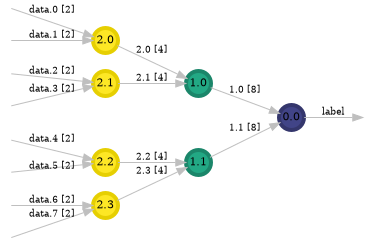

In [20]:
DTYPE = torch.double
DEVICE = 'cuda'
ttn = TTN(features, n_phys=2, n_labels=1, bond_dim=8, dtype=DTYPE, device=DEVICE)
ttn.draw()

In [63]:
data_batch = next(iter(train_dl))[0].squeeze().to(ttn.device, dtype=ttn.dtype)

vectors = ttn.get_do_dt('1.0', {TIndex(f'data.{i}', [f'data.{i}']): datum for i, datum in enumerate(data_batch.unbind(1))})

In [102]:
for tindex, tensor in vectors.items():
    print(tindex.name, tindex.indices, tensor.shape)

1.0 ['b' '1.0' 'label'] torch.Size([128, 8, 2])
2.0 ['b' '2.0'] torch.Size([128, 4])
2.1 ['b' '2.1'] torch.Size([128, 4])


## Test pathfinder

In [179]:
ttn.center = '2.2'
target = '2.3'

path = ttn.path_center_to_target(target)
print(path)

[TTNIndex: 2.2, TTNIndex: 1.1, TTNIndex: 2.3]


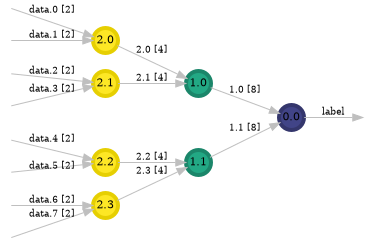

In [5]:
ttn.draw()

In [27]:
'data' not in TIndex('data.7', ['data.7']).name

False

In [49]:
ttn.path_from_to('data.2', '1.0')

[TIndex: data.2, TTNIndex: 2.1, TTNIndex: 1.0]

## test canonicalization

norm: 1.3662478366702324 1.86663315120609


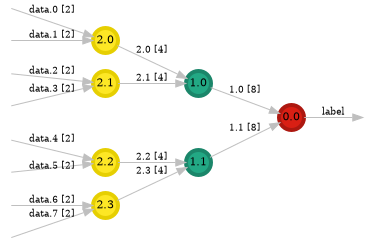

In [21]:
ttn.initialize(train_dl, class_loss, epochs=5, disable_pbar=True)
print('norm:', torch.linalg.vector_norm(ttn.tensors[0]).item(), (torch.linalg.vector_norm(ttn.tensors[0])**2).item())
ttn.draw()

In [22]:
ttn.normalize()

ttn canonicalization: 100%|██████████| 2/2 [00:00<00:00, 307.58it/s, canonicalized 1.1] 

norm: 1.0


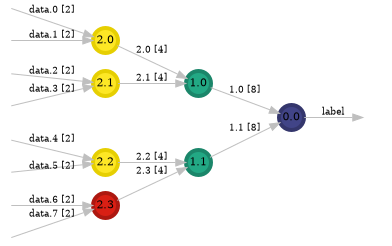

In [66]:
target = '2.3'
path = ttn.path_center_to_target(target)

pbar = tqdm(total=len(path)-1, desc="ttn canonicalization", position=0, leave=True)
ttn.canonicalize(target, pbar=pbar)
pbar.close()
print('norm:', torch.linalg.vector_norm(ttn[target][target]).item())
ttn.draw()

## Test expectation

In [16]:
ttn.expectation({TIndex(f'data.{i}', [f'data.{i}']): torch.eye(2, device=DEVICE, dtype=DTYPE) for i in [0, 1, 6]})

2.0
[TTNIndex: 0.0 TTNIndex: 1.0 TTNIndex: 1.1 TTNIndex: 2.0 TTNIndex: 2.3]
[TTNIndex: 2.0]
intermediate_results: {TIndex: data.0: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64), TIndex: data.1: tensor([[1., 0.],
        [0., 1.]], device='cuda:0', dtype=torch.float64), TTNIndex: 1.0: tensor([[ 1.0000e+00, -1.4011e-18, -7.0574e-18, -6.7006e-17],
        [-9.0716e-19,  1.0000e+00, -1.1797e-16,  5.9784e-18],
        [-6.0651e-18, -1.1289e-16,  1.0000e+00, -1.7237e-17],
        [-6.7634e-17,  4.0121e-18, -1.5225e-17,  1.0000e+00]], device='cuda:0',
       dtype=torch.float64)}
to_intersect {TTNIndex: 2.0: [TTNIndex: 1.0]}
prop_dict {TIndex: data.0: [TTNIndex: 2.0], TIndex: data.1: [TTNIndex: 2.0], TTNIndex: 1.0: [TTNIndex: 2.0]}


tensor(1.0000, device='cuda:0', dtype=torch.float64)

## test Entropy

In [23]:
ttn.entropy('label')

tensor(2.2204e-16, device='cuda:0', dtype=torch.float64)

## Test TTN derivative

## Test update

We apply the SGD instead of the conjugate gradient descent as the latter suppose that the derivative of the loss function is a linear function in the quantity we want to optimize but this is not the case

In [ ]:
def loss_derivative(labels: torch.Tensor, outputs: torch.Tensor, do_dt: torch.Tensor):

    # loss based on output dimension
    if len(outputs.squeeze().shape) > 1:
        return torch.mean(torch.sum((outputs.squeeze() - labels)*(do_dt*outputs.conj()+do_dt.conj()*outputs), -1))/2 
    else:
        return torch.mean((outputs.squeeze() - labels)**2)/2